In [21]:
import pandas as pd
import prisma_ml as prisma
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pickle
from sklearn.metrics import classification_report, roc_auc_score
import mlflow
import mlflow.sklearn
from xgboost import XGBClassifier
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 

In [22]:
df = pd.read_csv(r"../../data/processed/emotet_static.csv")

## EDA

In [23]:
info = prisma.DatasetInformation(df)

df.drop_duplicates(inplace=True)

info.dataframe_summary()

### Shape:

(79646, 32)

### Columns and Metadata:

,Data Type,Null Values,Percentage of Nulls
Duration,float64,0,0.0
Source Port,int64,0,0.0
Destination Port,int64,0,0.0
Protocol,object,0,0.0
Flags,object,0,0.0
Packets,int64,0,0.0
Bytes,int64,0,0.0
Mean Payload Size,float64,0,0.0
Std Payload Size,float64,0,0.0
Min Payload Size,int64,0,0.0


### Duplicated Rows:

,Duplicated Rows Count
Total,0


### Categorical

In [24]:
info = prisma.DatasetInformation(df)

info.categorical_summary()

### Categorical Columns Summary:

,Column,Unique Values Count,Top Value,Top Value Percentage
0,Protocol,4,TCP,76.17%
1,Flags,14,SYN,51.50%
2,Label,2,Benign,53.87%
3,direction,1,outbound,100.00%


### Column: Protocol

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,TCP,60663,76.165784
1,HTTP,14216,17.848982
2,DATA-TEXT-LINES,4743,5.955101
3,XML,24,0.030133


---

### Column: Flags

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,SYN,41015,51.496623
1,"PSH,ACK",18926,23.762650
2,"FIN,SYN,ACK",9294,11.669136
3,"SYN,RST,ACK",6277,7.881124
4,"FIN,SYN,RST,ACK",2958,3.713934
5,"FIN,SYN,PSH,ACK",556,0.698089
6,"SYN,ACK",289,0.362856
7,"FIN,SYN,RST,PSH,ACK",119,0.149411
8,"SYN,RST",64,0.080356
9,"SYN,PSH,ACK",53,0.066544


---

### Column: Label

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,Benign,42907,53.872134
1,Emotet,36739,46.127866


---

### Column: direction

#### Value Counts and Percentage Distribution:

,Value,Count,Percentage
0,outbound,79646,100.000000


---

### Numerical

## Modeling

### Final Data Prep

In [25]:
def save_as_pickle(path, variable):
    with open(path, "wb") as file:
        pickle.dump(variable, file)

#### Encoding

In [26]:
encoder = LabelEncoder()

# Columns to encode
columns_to_encode = ["Protocol", "Flags", "Label", "direction"]

# Apply label encoding to each column
for column in columns_to_encode:
    # Fit label encoder and return encoded labels
    path = "../../variables/emotet/static_no_pca" + column + "_Encoder.pkl"
    df[column] = encoder.fit_transform(df[column])
    save_as_pickle(path, encoder)

In [27]:
label_column = df["Label"]
dropped_df = df.drop("Label", axis=1)

# Initialize and apply MinMaxScaler to the dropped_df
scaler = StandardScaler()
scaled_dropped_df = scaler.fit_transform(dropped_df.to_numpy())
print(dropped_df.columns)
# Create a DataFrame from the scaled dropped_df
df = pd.DataFrame(scaled_dropped_df, columns=dropped_df.columns)

# Reattach the 'Status' column
df["Label"] = label_column

df.dropna(inplace=True)
df.reset_index()

Index(['Duration', 'Source Port', 'Destination Port', 'Protocol', 'Flags',
       'Packets', 'Bytes', 'Mean Payload Size', 'Std Payload Size',
       'Min Payload Size', 'Max Payload Size', 'Mean Entropy', 'Min Entropy',
       'Max Entropy', 'Mean Inter-Packet Interval',
       'Min Inter-Packet Interval', 'Max Inter-Packet Interval',
       'Bytes per Packet', 'Packets per Second', 'Bytes per Second',
       'Is Encrypted Traffic', 'Common Port Usage', 'flags_count', 'syn_count',
       'ack_count', 'fin_count', 'is_http', 'is_internal_ip', 'direction',
       'short_duration', 'single_packet'],
      dtype='object')


,index,Duration,Source Port,Destination Port,Protocol,Flags,Packets,Bytes,Mean Payload Size,Std Payload Size,...,flags_count,syn_count,ack_count,fin_count,is_http,is_internal_ip,direction,short_duration,single_packet,Label
0,0,-0.235028,0.194350,-0.945769,0.518607,-1.994489,0.292076,-0.029907,-0.524180,0.347024,...,1.326952,0.559436,1.032079,2.265765,-0.466123,0.566901,0.0,1.701821,-0.580762,0.0
1,1,-0.235028,-2.083208,1.412910,0.518607,-1.994489,0.292076,-0.031978,-0.534970,0.346977,...,1.326952,0.559436,1.032079,2.265765,-0.466123,-1.763976,0.0,1.701821,-0.580762,0.0
2,2,-0.235028,0.194350,-0.945769,-1.225838,-0.384668,-0.560901,-0.034308,-0.017037,0.347314,...,0.243789,-1.787514,1.032079,-0.441352,2.145358,0.566901,0.0,1.701821,1.721875,0.0
3,3,-0.235028,-2.083208,1.412910,-2.970283,-0.384668,-0.560901,-0.013081,0.425364,0.347339,...,0.243789,-1.787514,1.032079,-0.441352,-0.466123,-1.763976,0.0,1.701821,1.721875,0.0
4,4,-0.235005,0.194397,-0.561283,0.518607,0.420242,0.007750,-0.033532,-0.482817,0.346979,...,-0.839375,0.559436,-0.968918,-0.441352,-0.466123,0.566901,0.0,-0.587606,-0.580762,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79620,79641,-0.235005,0.445278,-0.561283,0.518607,0.420242,0.007750,-0.033532,-0.482817,0.346979,...,-0.839375,0.559436,-0.968918,-0.441352,-0.466123,0.566901,0.0,-0.587606,-0.580762,1.0
79621,79642,-0.234987,0.445324,-0.561283,0.518607,0.822697,0.292076,-0.029907,-0.524180,0.347024,...,0.243789,0.559436,1.032079,-0.441352,-0.466123,0.566901,0.0,-0.587606,-0.580762,1.0
79622,79643,-0.234988,-1.711945,1.672823,0.518607,-1.994489,0.007750,-0.040780,-0.533172,0.346979,...,1.326952,0.559436,1.032079,2.265765,-0.466123,-1.763976,0.0,-0.587606,-0.580762,0.0
79623,79644,-0.235028,0.445324,-0.561283,-1.225838,-0.384668,-0.560901,0.049305,1.725593,-2.535088,...,0.243789,-1.787514,1.032079,-0.441352,2.145358,0.566901,0.0,1.701821,1.721875,1.0


#### Type Casting

In [28]:
df["Bytes"] = df["Bytes"].astype("float64")
df["Duration"] = df["Duration"].astype("float64")
df["Packets"] = df["Packets"].astype("float64")
df["flags_count"] = df["flags_count"].astype("float64")

### Data Splitting

## Models

### Splitting

In [29]:
# Reset the index to convert it to a normal column (if needed)
df_reset = df.reset_index(drop=True)  # This will drop the old index column
X = df_reset.drop("Label", axis=1)  # Now drop the Label
if "index" in X.columns:
    X.drop("index", axis=1, inplace=True)
y = df["Label"]


# Assuming `X` is the feature matrix and `y` is the target variable
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

### KNN

In [30]:
from sklearn.neighbors import KNeighborsClassifier

# Define the model
knn_model = KNeighborsClassifier()

# Define hyperparameter grid
param_grid = {
    "n_neighbors": [3, 5, 7,],  # Number of neighbors to use
    "metric": ["euclidean", "manhattan"],  # Distance metric
}

# Perform Grid Search
grid_knn = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2,
)
grid_knn.fit(X_train, y_train)

# Best parameters
print("Best Parameters for KNN:", grid_knn.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[CV] END ....................metric=euclidean, n_neighbors=5; total time=   6.1s
[CV] END ....................metric=euclidean, n_neighbors=7; total time=   6.2s
[CV] END ....................metric=euclidean, n_neighbors=7; total time=   6.3s
[CV] END ....................metric=euclidean, n_neighbors=7; total time=   6.5s
[CV] END ....................metric=euclidean, n_neighbors=7; total time=   6.6s
[CV] END ....................metric=euclidean, n_neighbors=3; total time=   6.7s
[CV] END ....................metric=euclidean, n_neighbors=5; total time=   6.8s
[CV] END ....................metric=euclidean, n_neighbors=3; total time=   7.3s
[CV] END ....................metric=euclidean, n_neighbors=3; total time=   7.3s
[CV] END ....................metric=euclidean, n_neighbors=3; total time=   7.3s
[CV] END ....................metric=euclidean, n_neighbors=5; total time=   7.4s
[CV] END ....................metric=euclidean, n_neighbors=7; total time=   7.4s
[CV] END ...................

/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## XGB

In [31]:

# Define the model
xgb_model = XGBClassifier(
    use_label_encoder=False, eval_metric="logloss", random_state=42
)

# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
}

# Perform Grid Search
grid_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2,
)
grid_xgb.fit(X_train, y_train)

# Best parameters
print("Best Parameters for XGBoost:", grid_xgb.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:38] WARNING: /workspace/src/lea

[CV] END .................learning_rate=0.1, n_estimators=50; total time=   1.0s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.1s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.1s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.2s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.2s
[CV] END ................learning_rate=0.01, n_estimators=50; total time=   1.2s


/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:40] WARNING: /workspace/src/lea

[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   1.7s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   1.8s


/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   2.0s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   2.0s
[CV] END ...............learning_rate=0.01, n_estimators=100; total time=   2.0s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=   1.0s
[CV] END .................learning_rate=0.1, n_estimators=50; total time=   1.0s


/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END .................learning_rate=0.1, n_estimators=50; total time=   1.1s


/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:41] WARNING: /workspace/src/lea

[CV] END .................learning_rate=0.1, n_estimators=50; total time=   1.8s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   1.7s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   1.8s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   1.7s


/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   3.6s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   3.7s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   3.7s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   2.0s


/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   3.8s


/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END .................learning_rate=0.2, n_estimators=50; total time=   1.2s
[CV] END ................learning_rate=0.1, n_estimators=100; total time=   2.2s
[CV] END ...............learning_rate=0.01, n_estimators=200; total time=   4.2s
[CV] END .................learning_rate=0.2, n_estimators=50; total time=   1.3s
[CV] END .................learning_rate=0.2, n_estimators=50; total time=   1.0s


/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END .................learning_rate=0.2, n_estimators=50; total time=   1.4s


/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:43] WARNING: /workspace/src/lea

[CV] END ................learning_rate=0.1, n_estimators=200; total time=   2.7s
[CV] END ................learning_rate=0.1, n_estimators=200; total time=   2.6s
[CV] END .................learning_rate=0.2, n_estimators=50; total time=   1.2s
[CV] END ................learning_rate=0.1, n_estimators=200; total time=   2.9s
[CV] END ................learning_rate=0.1, n_estimators=200; total time=   2.9s
[CV] END ................learning_rate=0.2, n_estimators=100; total time=   1.5s
[CV] END ................learning_rate=0.2, n_estimators=100; total time=   1.5s
[CV] END ................learning_rate=0.2, n_estimators=100; total time=   1.5s
[CV] END ................learning_rate=0.1, n_estimators=200; total time=   3.1s
[CV] END ................learning_rate=0.2, n_estimators=100; total time=   1.7s
[CV] END ................learning_rate=0.2, n_estimators=100; total time=   1.4s
[CV] END ................learning_rate=0.2, n_estimators=200; total time=   1.8s
[CV] END ................lea

/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:41:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters for XGBoost: {'learning_rate': 0.2, 'n_estimators': 100}


### Random Forest

In [32]:


rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [10, 20, None],
}

# Perform Grid Search
grid_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2,
)
grid_rf.fit(X_train, y_train)

# Best parameters
print("Best Parameters for Random Forest:", grid_rf.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......................max_depth=10, n_estimators=50; total time=   3.3s
[CV] END ......................max_depth=10, n_estimators=50; total time=   3.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=   3.4s
[CV] END ......................max_depth=10, n_estimators=50; total time=   3.6s
[CV] END ......................max_depth=10, n_estimators=50; total time=   3.6s
[CV] END ......................max_depth=20, n_estimators=50; total time=   4.0s
[CV] END .....................max_depth=10, n_estimators=100; total time=   6.7s
[CV] END .....................max_depth=10, n_estimators=100; total time=   6.9s
[CV] END .....................max_depth=10, n_estimators=100; total time=   7.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   7.2s
[CV] END ......................max_depth=20, n_estimators=50; total time=   4.1s
[CV] END ......................max_depth=20, n_es

### Logistic Regression

In [33]:

# Define the model
log_reg_model = LogisticRegression(solver="liblinear", random_state=42)

# Define hyperparameter grid
param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.01, 0.1, 1, 10],
}

# Perform Grid Search
grid_log_reg = GridSearchCV(
    estimator=log_reg_model,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=2,
)
grid_log_reg.fit(X_train, y_train)

# Best parameters
print("Best Parameters for Logistic Regression:", grid_log_reg.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END .................................C=0.01, penalty=l2; total time=   3.8s
[CV] END .................................C=0.01, penalty=l2; total time=   4.5s
[CV] END .................................C=0.01, penalty=l2; total time=   4.7s
[CV] END .................................C=0.01, penalty=l2; total time=   4.7s
[CV] END .................................C=0.01, penalty=l2; total time=   4.8s
[CV] END .................................C=0.01, penalty=l1; total time=   7.7s
[CV] END ..................................C=0.1, penalty=l2; total time=   7.5s
[CV] END .................................C=0.01, penalty=l1; total time=   8.0s
[CV] END .................................C=0.01, penalty=l1; total time=   9.7s
[CV] END .................................C=0.01, penalty=l1; total time=  10.2s
[CV] END ..................................C=0.1, penalty=l2; total time=   6.6s
[CV] END .................................C=0.01,

/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...................................C=10, penalty=l1; total time= 4.6min
[CV] END ...................................C=10, penalty=l1; total time= 4.5min


/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ...................................C=10, penalty=l1; total time= 4.7min
[CV] END ...................................C=10, penalty=l1; total time= 4.6min
[CV] END ...................................C=10, penalty=l1; total time= 4.8min
Best Parameters for Logistic Regression: {'C': 1, 'penalty': 'l2'}


### Model Evaluation

In [50]:
# Create a function for evaluation
def evaluate_model(model, X_val, y_val, X_test, y_test, model_name):
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)

    # Log metrics
    val_metrics = classification_report(y_val, y_val_pred, output_dict=True)
    print(val_metrics)
    print(model.get_params())
    test_metrics = classification_report(y_test, y_test_pred, output_dict=True)
    roc_auc_val = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
    roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Log with MLflow
    with mlflow.start_run(run_name=model_name):
        mlflow.log_params(model.get_params())
        mlflow.log_metric("Accuracy_Validation", val_metrics["accuracy"])
        mlflow.log_metric("Precision_Validation", val_metrics["1.0"]["precision"])
        mlflow.log_metric("Recall_Validation", val_metrics["1.0"]["recall"])
        mlflow.log_metric("F1-Score Validation", val_metrics["1.0"]["f1-score"])
        mlflow.log_metric("ROC-AUC Validation", roc_auc_val)

        mlflow.log_metric("Accuracy_Test", test_metrics["accuracy"])
        mlflow.log_metric("Precision_Test", test_metrics["1.0"]["precision"])
        mlflow.log_metric("Recall_Test", test_metrics["1.0"]["recall"])
        mlflow.log_metric("F1-Score_Test", test_metrics["1.0"]["f1-score"])
        mlflow.log_metric("ROC-AUC_Test", roc_auc_test)

        mlflow.sklearn.log_model(model, f"{model_name}_model")

    # Print metrics
    print(f"Validation Metrics for {model_name}:")
    print(classification_report(y_val, y_val_pred))
    print(f"ROC-AUC (Validation): {roc_auc_val}\n")

    print(f"Test Metrics for {model_name}:")
    print(classification_report(y_test, y_test_pred))
    print(f"ROC-AUC (Test): {roc_auc_test}\n")

In [52]:
mlflow.set_experiment("Standard Scaler")
evaluate_model(
    grid_log_reg.best_estimator_, X_val, y_val, X_test, y_test, "Logistic Regression"
)
evaluate_model(grid_knn.best_estimator_, X_val, y_val, X_test, y_test, "knn")
evaluate_model(grid_xgb.best_estimator_, X_val, y_val, X_test, y_test, "XGBoost")
evaluate_model(grid_rf.best_estimator_, X_val, y_val, X_test, y_test, "Random Forest")

{'0.0': {'precision': 0.8604538870111057, 'recall': 0.8308983525023313, 'f1-score': 0.8454178856645845, 'support': 6434.0}, '1.0': {'precision': 0.8101552957599023, 'recall': 0.8426497277676951, 'f1-score': 0.8260830886931768, 'support': 5510.0}, 'accuracy': 0.8363194909578031, 'macro avg': {'precision': 0.835304591385504, 'recall': 0.8367740401350132, 'f1-score': 0.8357504871788807, 'support': 11944.0}, 'weighted avg': {'precision': 0.8372501664992059, 'recall': 0.8363194909578031, 'f1-score': 0.8364983669679622, 'support': 11944.0}}
{'C': 1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


2025/01/15 20:59:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation Metrics for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.85      6434
         1.0       0.81      0.84      0.83      5510

    accuracy                           0.84     11944
   macro avg       0.84      0.84      0.84     11944
weighted avg       0.84      0.84      0.84     11944

ROC-AUC (Validation): 0.8887465184672848

Test Metrics for Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.86      0.82      0.84      6435
         1.0       0.80      0.84      0.82      5509

    accuracy                           0.83     11944
   macro avg       0.83      0.83      0.83     11944
weighted avg       0.83      0.83      0.83     11944

ROC-AUC (Test): 0.8775316452571852

{'0.0': {'precision': 0.9114426281542612, 'recall': 0.892601802921977, 'f1-score': 0.9019238319591677, 'support': 6434.0}, '1.0': {'precision': 0.8775474038631933, 'recall': 0.8987295825

2025/01/15 20:59:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation Metrics for knn:
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      6434
         1.0       0.88      0.90      0.89      5510

    accuracy                           0.90     11944
   macro avg       0.89      0.90      0.89     11944
weighted avg       0.90      0.90      0.90     11944

ROC-AUC (Validation): 0.9478114931621766

Test Metrics for knn:
              precision    recall  f1-score   support

         0.0       0.91      0.89      0.90      6435
         1.0       0.87      0.90      0.89      5509

    accuracy                           0.89     11944
   macro avg       0.89      0.89      0.89     11944
weighted avg       0.89      0.89      0.89     11944

ROC-AUC (Test): 0.9464711061915638

{'0.0': {'precision': 0.9399321814952366, 'recall': 0.9047248989741996, 'f1-score': 0.9219925556347509, 'support': 6434.0}, '1.0': {'precision': 0.8934098417666493, 'recall': 0.932486388384755, 'f1-score': 0.9125299706

2025/01/15 20:59:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation Metrics for XGBoost:
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      6434
         1.0       0.89      0.93      0.91      5510

    accuracy                           0.92     11944
   macro avg       0.92      0.92      0.92     11944
weighted avg       0.92      0.92      0.92     11944

ROC-AUC (Validation): 0.9706650580767893

Test Metrics for XGBoost:
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      6435
         1.0       0.89      0.93      0.91      5509

    accuracy                           0.92     11944
   macro avg       0.91      0.92      0.92     11944
weighted avg       0.92      0.92      0.92     11944

ROC-AUC (Test): 0.9695540658691866

{'0.0': {'precision': 0.936955820702999, 'recall': 0.9031706558905813, 'f1-score': 0.9197530864197531, 'support': 6434.0}, '1.0': {'precision': 0.891501219087426, 'recall': 0.929038112522686, 'f1-score': 0.9098

2025/01/15 20:59:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Validation Metrics for Random Forest:
              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      6434
         1.0       0.89      0.93      0.91      5510

    accuracy                           0.92     11944
   macro avg       0.91      0.92      0.91     11944
weighted avg       0.92      0.92      0.92     11944

ROC-AUC (Validation): 0.9627777116464428

Test Metrics for Random Forest:
              precision    recall  f1-score   support

         0.0       0.93      0.90      0.92      6435
         1.0       0.89      0.92      0.91      5509

    accuracy                           0.91     11944
   macro avg       0.91      0.91      0.91     11944
weighted avg       0.91      0.91      0.91     11944

ROC-AUC (Test): 0.9626948936987056



In [51]:
mlflow.end_run()

## Validation

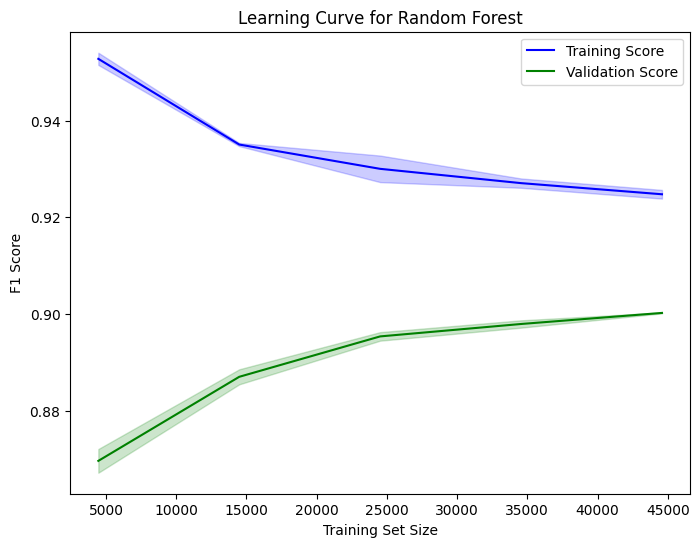

In [53]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    grid_rf.best_estimator_, X_train, y_train, cv=5, scoring="f1", n_jobs=-1
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(
    train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2
)
plt.plot(train_sizes, val_mean, label="Validation Score", color="green")
plt.fill_between(
    train_sizes, val_mean - val_std, val_mean + val_std, color="green", alpha=0.2
)
plt.title("Learning Curve for Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

In [57]:
print("Train Mean:", train_mean)
print("Validation Mean:", val_mean)

Train Mean: [0.92813621 0.91646082 0.91367012 0.91250641 0.91137991]
Validation Mean: [0.88818821 0.90220197 0.90426218 0.90512909 0.90714748]


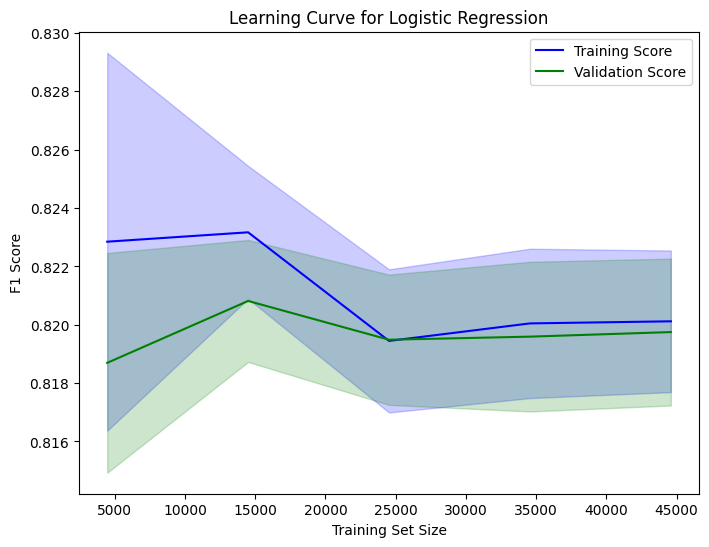

In [54]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    grid_log_reg.best_estimator_, X_train, y_train, cv=5, scoring="f1", n_jobs=-1
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(
    train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2
)
plt.plot(train_sizes, val_mean, label="Validation Score", color="green")
plt.fill_between(
    train_sizes, val_mean - val_std, val_mean + val_std, color="green", alpha=0.2
)
plt.title("Learning Curve for Logistic Regression")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

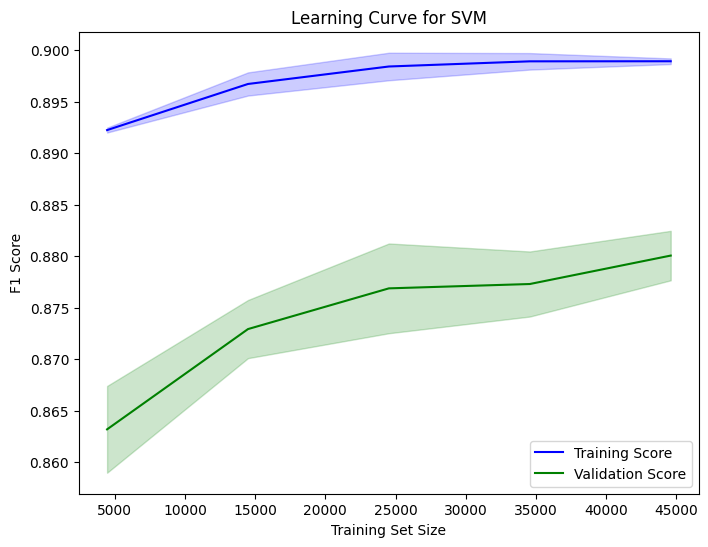

In [55]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    grid_knn.best_estimator_, X_train, y_train, cv=5, scoring="f1", n_jobs=-1
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(
    train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2
)
plt.plot(train_sizes, val_mean, label="Validation Score", color="green")
plt.fill_between(
    train_sizes, val_mean - val_std, val_mean + val_std, color="green", alpha=0.2
)
plt.title("Learning Curve for SVM")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:02:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:02:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:02:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/yousinator/.cache/pypoetry/virtualenvs/c2-detection-TvTzD0kY-py3.10/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:02:05] WARNING: /workspace/src/lea

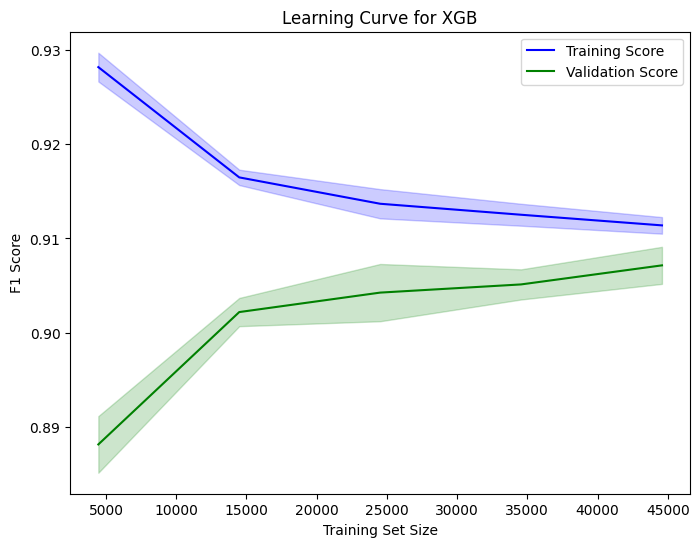

In [56]:
train_sizes, train_scores, val_scores = learning_curve(
    grid_xgb.best_estimator_, X_train, y_train, cv=5, scoring="f1", n_jobs=-1
)

# Calculate means and standard deviations
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training Score", color="blue")
plt.fill_between(
    train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2
)
plt.plot(train_sizes, val_mean, label="Validation Score", color="green")
plt.fill_between(
    train_sizes, val_mean - val_std, val_mean + val_std, color="green", alpha=0.2
)
plt.title("Learning Curve for XGB")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend()
plt.show()